# csaQTL GWAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cna, pickle, os, pp 
from matplotlib import lines
from matplotlib.patches import ConnectionPatch
gw_sig = 5e-08

res_folder = "/data/srlab/lrumker/MCSC_Project/cna-qtl/results/"
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

## Table of genome-wide significant loci

In [2]:
loci = pd.DataFrame({})
for celltype in ["Myeloid", "NK"]:
    loci = pd.concat((loci, pd.read_csv(res_folder+"gwas_"+celltype+"/gwas_loci.tsv", sep = "\t")))
loci.reset_index(inplace=True, drop=True)
loci['Cell Type'] = loci.celltype.values
loci['SNP'] = loci.ID.values
loci['CHR'] = loci['#CHROM'].values

other_allele = []
effect_allele = []
rsID = []
cytogenetic_band = []
for i_locus in np.arange(loci.shape[0]):
    celltype = loci.iloc[i_locus, :].celltype
    sel_chr = loci.iloc[i_locus, :]['#CHROM']
    sel_SNP = loci.iloc[i_locus, :].SNP
    annovar = pd.read_table(res_folder+"annovar/"+celltype+"_"+loci.SNP[i_locus]+"_cis.hg19_multianno.txt")
    annovar["SNP"] = [str(annovar.Chr.values[i])+":"+str(annovar.End.values[i])+":"+\
                     annovar.Ref.values[i]+":"+annovar.Alt.values[i] for i in np.arange(annovar.shape[0])]
    annovar.set_index('SNP', inplace = True, drop = True)
    other_allele.append(annovar.loc[sel_SNP,'Ref'])
    effect_allele.append(annovar.loc[sel_SNP,'Alt'])
    rsID.append(annovar.loc[sel_SNP,'avsnp147'])
    cytogenetic_band.append(annovar.loc[sel_SNP,'cytoBand'])
loci['Effect Allele'] = effect_allele
loci['Other Allele'] = other_allele
loci['rsID'] = rsID
loci['Cyto. Band'] = cytogenetic_band

export = loci.loc[:,['Cell Type', 'CHR', 'POS', 'rsID', 'Effect Allele', 
                         'Other Allele', 'Cyto. Band', 'MAF', 'P']]
export['MAF'] = [np.around(export.MAF.values[i], 2) for i in np.arange(export.shape[0])]
export['P'] = ['{:.2e}'.format(export.P.values[i]) for i in np.arange(export.shape[0])]

/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,11,12,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,11,12,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.gwas_loci.tex','w') as tf:
    tf.write(export.to_latex(index = False))
export

,Cell Type,CHR,POS,rsID,Effect Allele,Other Allele,Cyto. Band,MAF,P
0,Myeloid,15,80263217,rs3826007,T,C,15q25.1,0.27,2.61e-08
1,NK,2,111851212,rs13025330,T,C,2q13,0.22,1.76e-09
2,NK,11,128070535,rs519062,G,A,11q24.3,0.28,2.48e-13
3,NK,12,10583611,rs3003,T,C,12p13.2,0.18,1.96e-11
4,NK,19,16441973,rs56133626,A,G,19p13.11,0.33,1.96e-13


In [4]:
loci["Phenotype Annotation"] = ['Decrease in CD16+ monocytes \% myeloid cells',
                            'Decrease in CD56bright \% NK cells',
                             r'Increase in NK cells activated by TNF-$\alpha$ and IFN-$\gamma$'+' \% NK cells',
                            r'Increase in NK cells activated by TNF-$\alpha$, IFN-$\gamma$, IL-2, and IL-6'+' \% NK cells',
                            r'Increase in NK cells activated by TNF-$\alpha$'+' \% NK cells']
loci['Novel'] = ['No', 'No', 'Yes', 'Yes', 'Yes']

with pd.option_context("max_colwidth", 1000): # avoids text truncation within cells with long strings
    with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.loci_phenos.tex','w') as tf:
        tf.write(loci.loc[:,['Cell Type', 'CHR', 'Phenotype Annotation', 'Novel']].to_latex(index = False, escape=False))
loci.to_csv(res_folder+"loci_table.tsv", sep = "\t", index = False)
loci.loc[:,['Cell Type', 'CHR', 'Phenotype Annotation', 'Novel']]

,Cell Type,CHR,Phenotype Annotation,Novel
0,Myeloid,15,Decrease in CD16+ monocytes \% myeloid cells,No
1,NK,2,Decrease in CD56bright \% NK cells,No
2,NK,11,Increase in NK cells activated by TNF-$\alpha$...,Yes
3,NK,12,Increase in NK cells activated by TNF-$\alpha$...,Yes
4,NK,19,Increase in NK cells activated by TNF-$\alpha$...,Yes


## Manhattan plots by major cell type

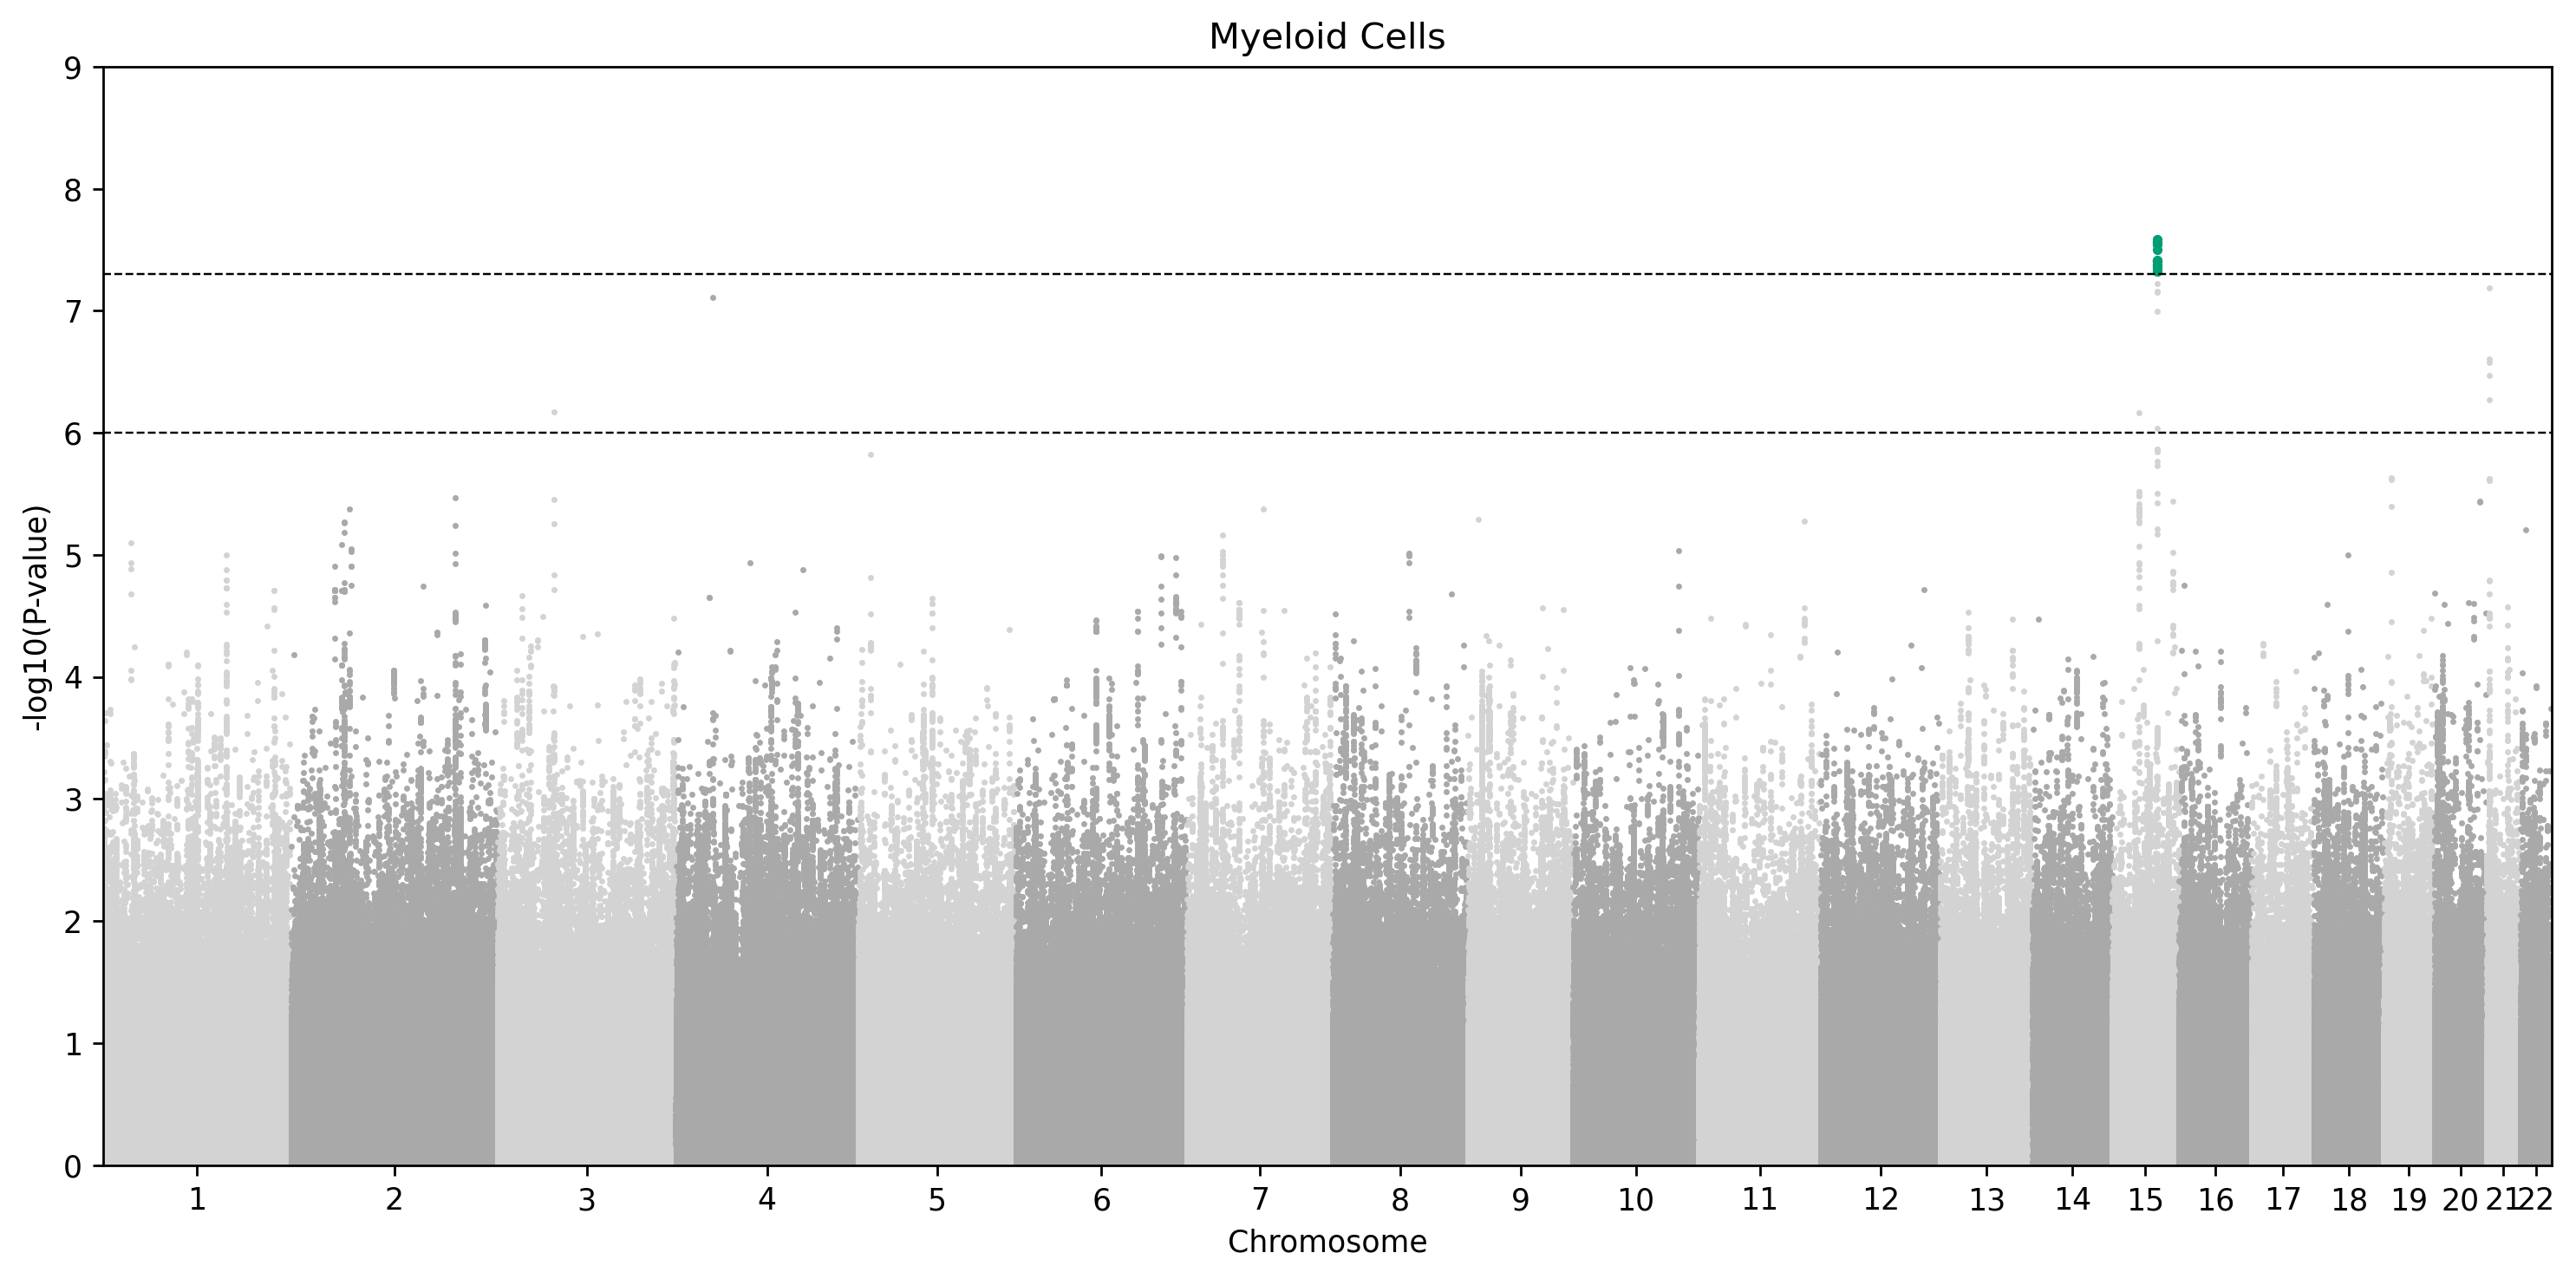

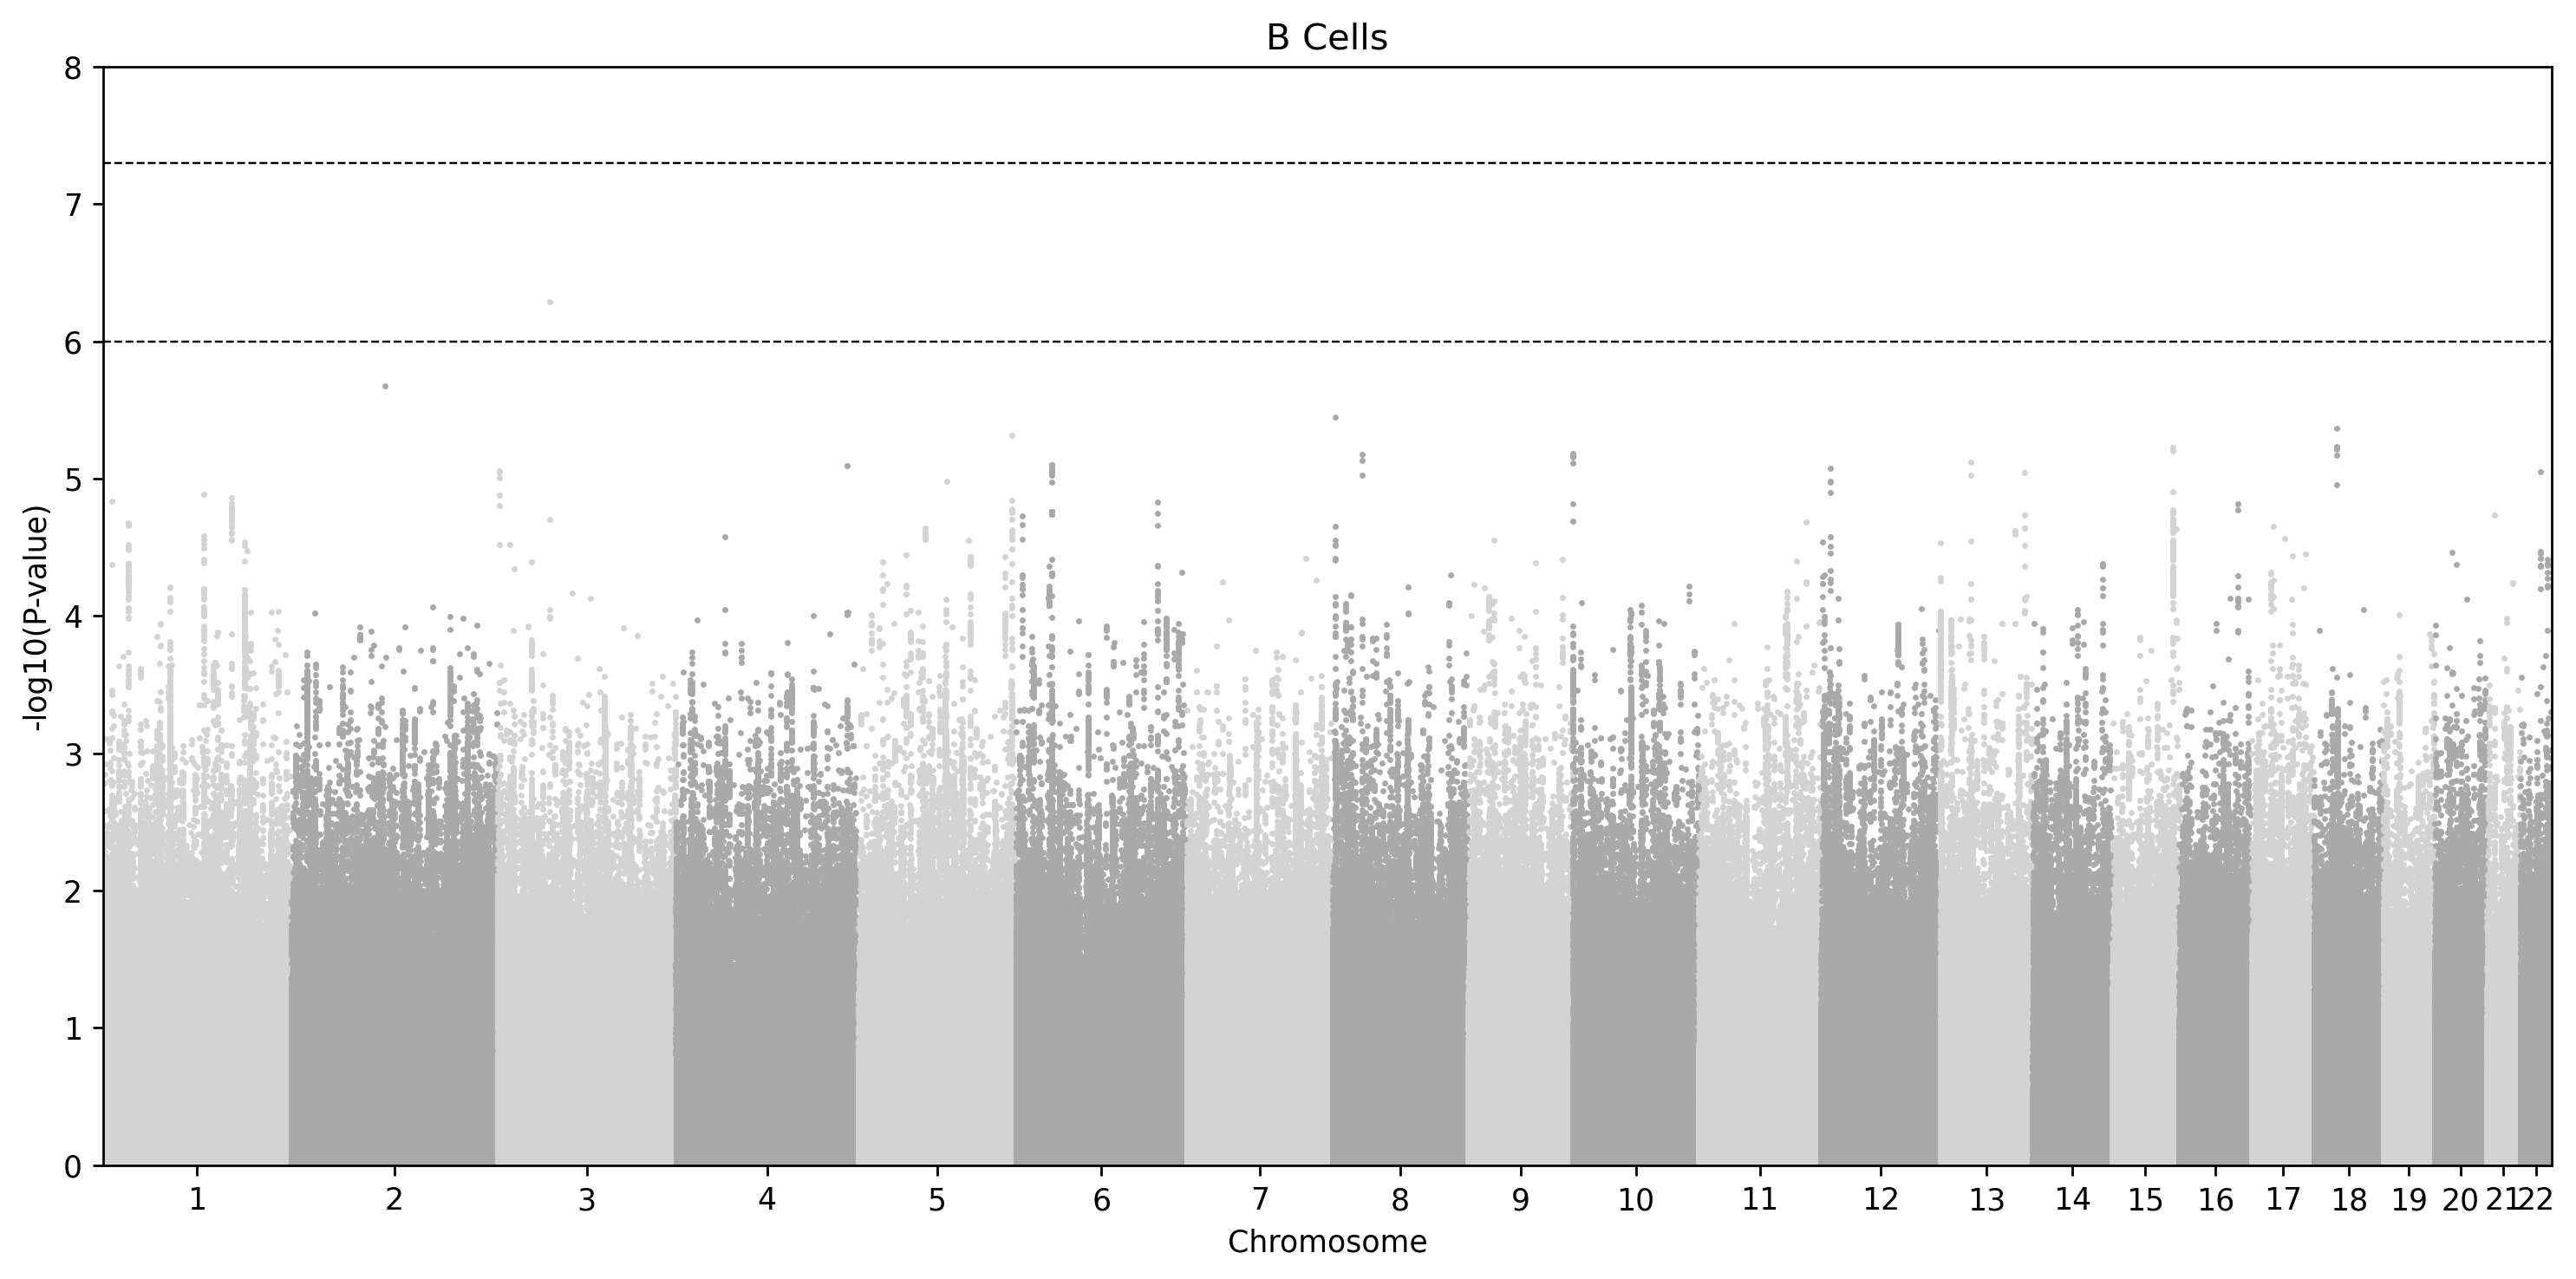

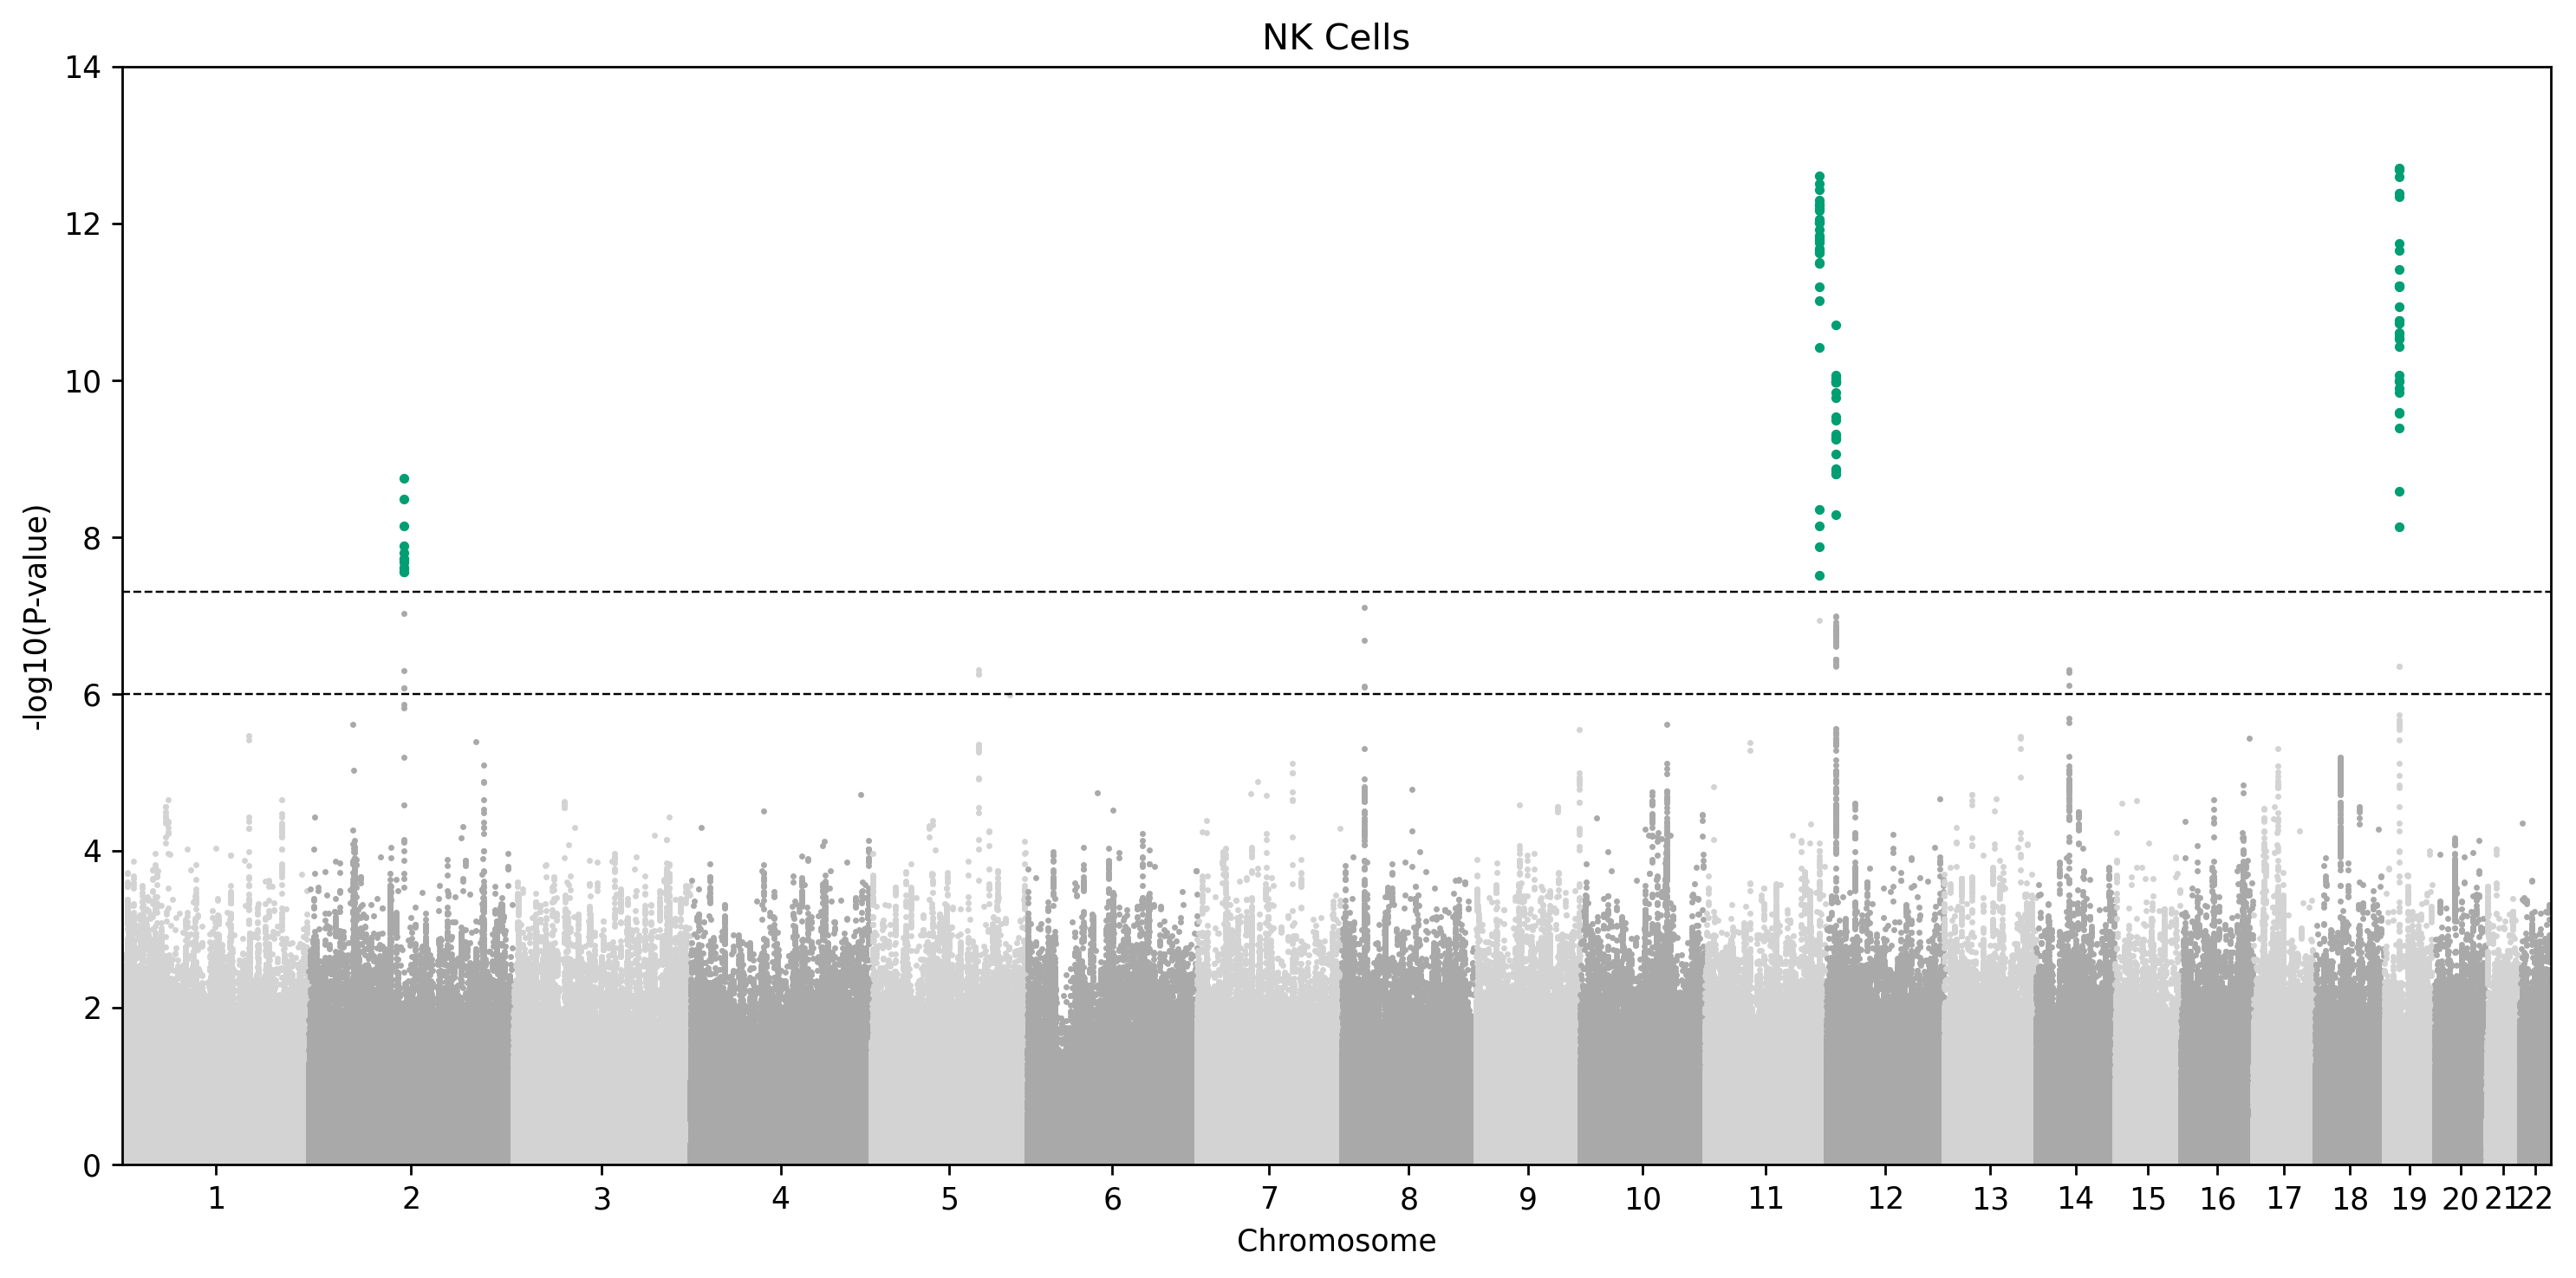

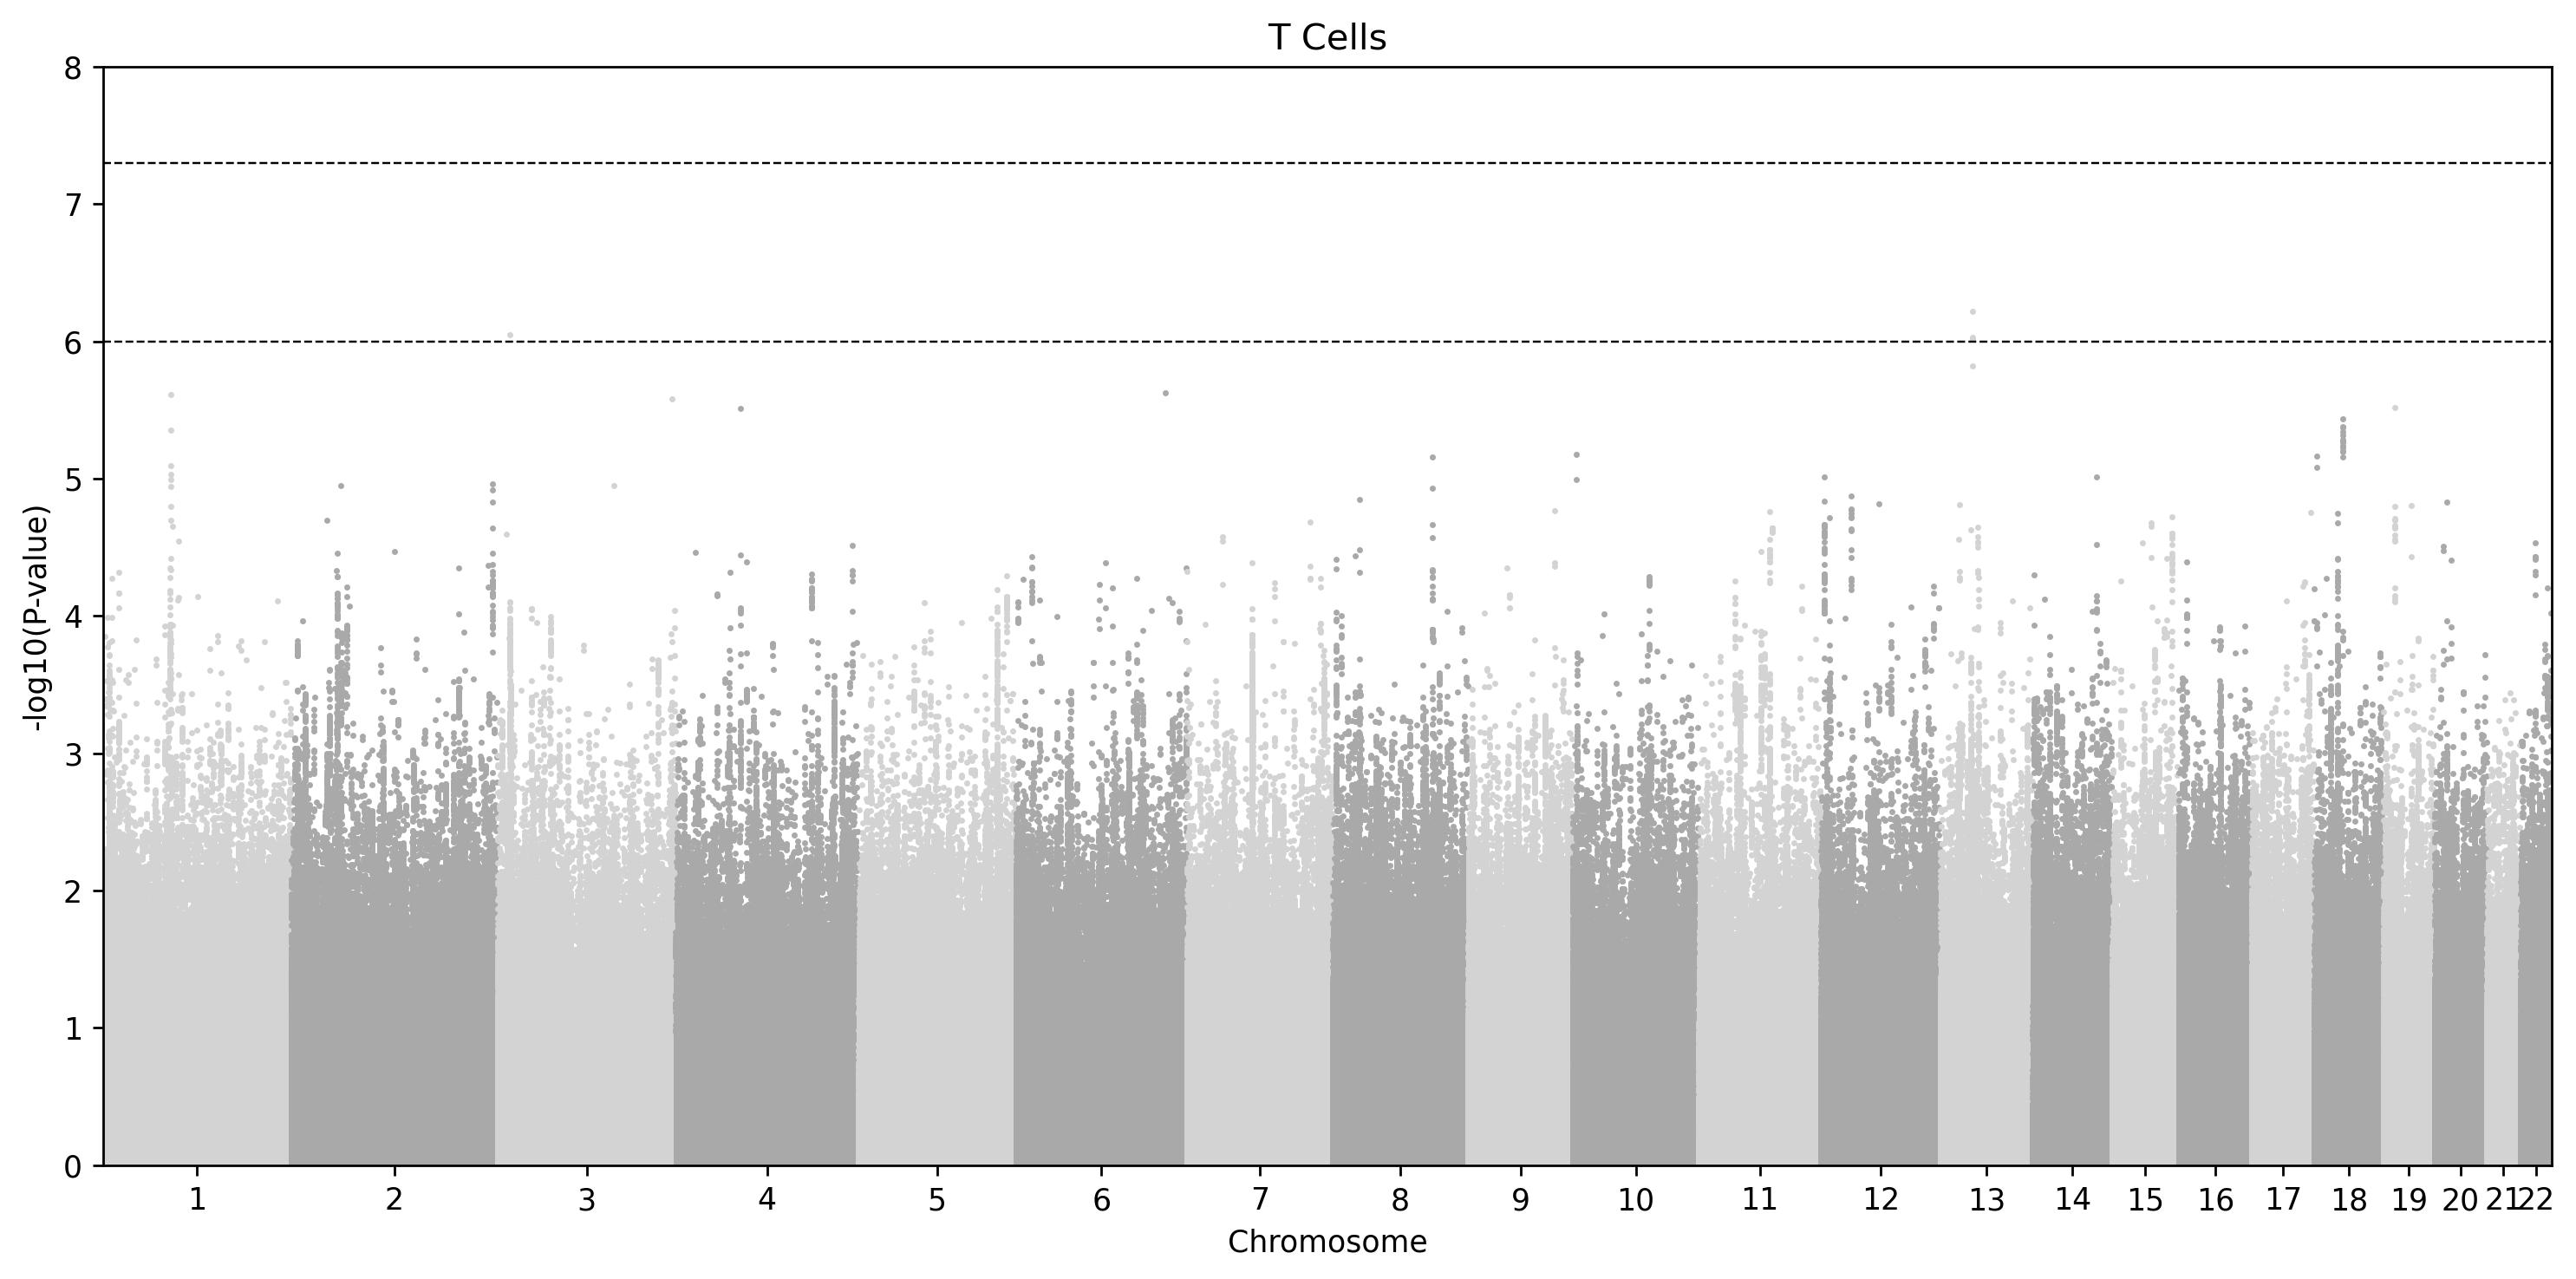

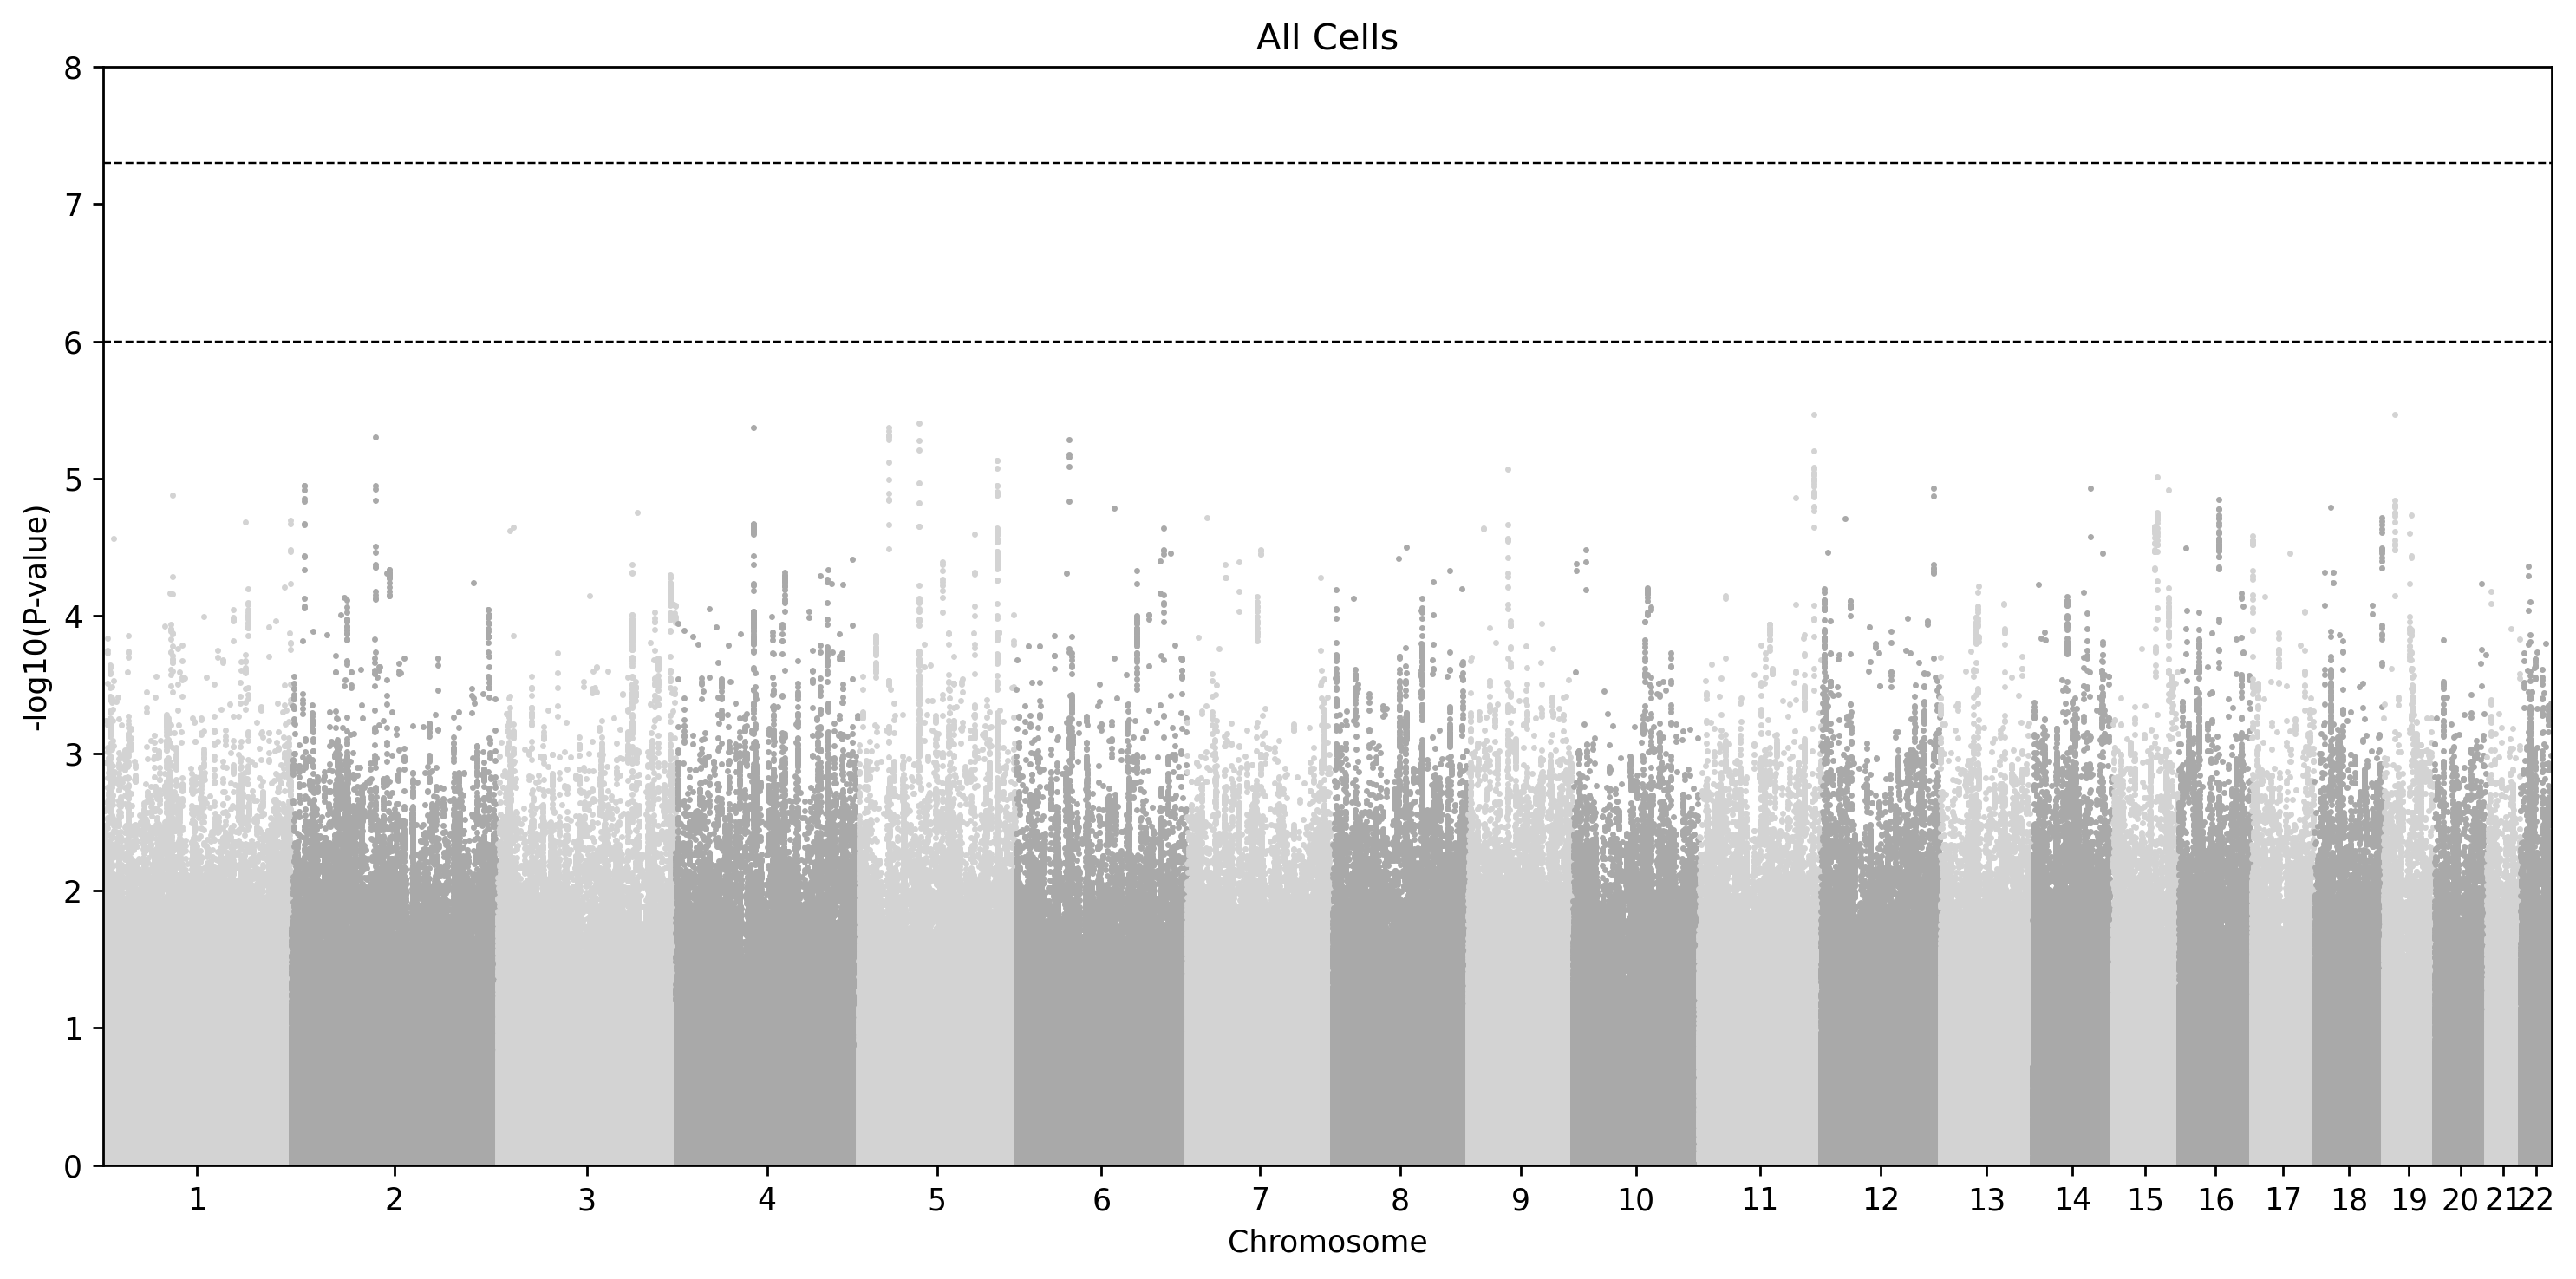

In [5]:
celltypes = ["Myeloid", "B", "NK", "T", "allcells"]

for i in np.arange(len(celltypes)):
    celltype = celltypes[i]
    
    # Load gwas results
    res = pd.read_csv(res_folder+"gwas_"+celltype+"/GeNA_sumstats.txt", sep = "\t")
    reordered_res = pd.DataFrame({})
    for sel_chr in np.arange(1,23):
        sub_res = res.loc[res['#CHROM']==sel_chr,:].reset_index(drop=True)
        sub_res = sub_res.iloc[np.argsort(sub_res['POS']),:]
        reordered_res = pd.concat([reordered_res, sub_res])
    res = reordered_res
    
    res['log10p'] = -np.log10(res['P'])
    res['ind'] = range(res.shape[0])
    res_grouped = res.groupby(('#CHROM'))
    res = res.astype({'#CHROM':'string'})

    # Generate plot
    fig = plt.figure(figsize=(12, 6), dpi = 250) # Set the figure size
    ax = fig.add_subplot(111)
    colors = ['lightgrey', 'darkgrey']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(res_grouped):
        group.plot(kind='scatter', x='ind', y='log10p',color=colors[num % len(colors)], ax=ax, s=1, rasterized = True)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    
    res.loc[res.P.values < gw_sig,:].plot(kind='scatter', x='ind', y='log10p',
       color=color_dict['green'], ax=ax, s=5, rasterized = True)

    # set axis limits
    ax.set_xlim([0, len(res)])
    ax.set_ylim([0, np.max([8,np.ceil(np.max(res.log10p))+1])])

    # x axis label
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(P-value)')

    # Add p-value thresholds
    ax.axhline(y=-np.log10(gw_sig), linestyle="--", color = "black", lw=0.7)
    ax.axhline(y=-np.log10(1e-6), linestyle="--", color = "black", lw=0.7)

    if celltype=="allcells":
        plt.title("All Cells")
    else:
        plt.title(celltype+" Cells")
    plt.tight_layout()
    plt.savefig(fig_dir+"gwas_"+celltype+".png", dpi = 300, transparent=True)
    plt.show()

## Main figure: Joint NK and myeloid manhattan plot

In [6]:
# Load gwas results Myeloid
type_res = pd.read_csv(res_folder+"gwas_Myeloid/GeNA_sumstats.txt", sep = "\t")
type_res['celltype']= np.repeat("Myeloid", type_res.shape[0])
reordered_res = pd.DataFrame({})
for sel_chr in np.arange(1,23):
    sub_res = type_res.loc[type_res['#CHROM']==sel_chr,:].reset_index(drop=True)
    sub_res = sub_res.iloc[np.argsort(sub_res['POS']),:]
    reordered_res = pd.concat([reordered_res, sub_res])
type_res = reordered_res
type_res['ind'] = range(type_res.shape[0])
res = type_res

# Load gwas results NK
type_res = pd.read_csv(res_folder+"gwas_NK/GeNA_sumstats.txt", sep = "\t")
type_res['celltype']= np.repeat("NK", type_res.shape[0])
reordered_res = pd.DataFrame({})
for sel_chr in np.arange(1,23):
    sub_res = type_res.loc[type_res['#CHROM']==sel_chr,:].reset_index(drop=True)
    sub_res = sub_res.iloc[np.argsort(sub_res['POS']),:]
    reordered_res = pd.concat([reordered_res, sub_res])
type_res = reordered_res
type_res['ind'] = range(type_res.shape[0])

# Combine
res = pd.concat([res, type_res])
res = res.iloc[np.argsort(res.index),:].reset_index(drop = True)
res.reset_index(drop=True, inplace = True)

res['log10p'] = -np.log10(res['P'])
res_grouped = res.groupby(('#CHROM'))
res = res.astype({'#CHROM':'string'})

In [7]:
d_m = cna.read('/data/srlab/lrumker/datasets/onek1k/pheno/Myeloid.h5ad')
UMAP1_m=d_m.obsm['X_umap'][d_m.uns['keptcells'],0]
UMAP2_m=d_m.obsm['X_umap'][d_m.uns['keptcells'],1]

d_nk = cna.read('/data/srlab/lrumker/datasets/onek1k/pheno/NK.h5ad')
UMAP1_nk=d_nk.obsm['X_umap'][d_nk.uns['keptcells'],0]
UMAP2_nk=d_nk.obsm['X_umap'][d_nk.uns['keptcells'],1]

m_type_colors = {'CD14 Mono': color_dict['purple'], 'CD16 Mono': color_dict['yellow'], 
                 'cDC2': color_dict['green'], 'pDC': color_dict['orange'], 
                 'ASDC': color_dict['skyblue'], 'cDC1': color_dict['oceanblue']}

nk_type_colors = {'NK': color_dict['skyblue'], 'NK_CD56bright': color_dict['orange'], 
                 'NK Proliferating': color_dict['yellow'], 'ILC': color_dict['purple']}

In [8]:
def pheno_scatter(UMAP1, UMAP2, allele, celltype, ax, title, subfiglabel):
    res = pickle.load(open('/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_'+celltype+\
                           "/cna_res_"+allele+'.p','rb'))
    pp.scatter_random(UMAP1, UMAP2, c = res.ncorrs, symmetrize = False, cmap = "seismic", ax = ax)
    ax.set_title(title)
    ax.text(0, 1.05, subfiglabel, fontsize=15,horizontalalignment='left',
            verticalalignment='center', transform = ax.transAxes, fontweight="bold")
    ax.axis("off")

In [ ]:
fig = plt.figure(tight_layout=True, figsize = (17,8), dpi=400, facecolor='white')
pp.umapprops['s'] = 1

gs2 = fig.add_gridspec(1, 2)
gs2.update(bottom=0, left=0, top=1, right=1) 
ax_cbar_labs = fig.add_subplot(gs2[0])
ax_cbar_labs.text(0,0.75,'Abundance correlation', fontsize=8, rotation = 90)
ax_cbar_labs.text(0.04,0.74,'Neg', fontsize=8)
ax_cbar_labs.text(0.04,0.9,'Pos', fontsize=8)
ax_cbar_labs.axis("off")
ax_cbar_labs.set_in_layout(False)

gs2 = fig.add_gridspec(1, 2)
gs2.update(bottom=0.65, left=0, top=1, right=0.2) 
ax_cbar = fig.add_subplot(gs2[0])
ax_cbar.axis("off")
ax_cbar.set_in_layout(False)

locus_res = pickle.load(open('/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_NK/cna_res_2:111851212:C:T.p','rb'))
cbar_plot = ax_cbar.scatter(UMAP1_nk, UMAP2_nk, c = locus_res.ncorrs, s=0.001, cmap="seismic")
cbar = plt.colorbar(cbar_plot, ticks = [], shrink=0.5, location='left', ax = ax_cbar, pad = 0.9)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cbar_plot = ax_cbar.scatter(UMAP1_nk, UMAP2_nk, c = "white", s=0.1, cmap="seismic", alpha=1)
ax_cbar.axis("off")
ax_cbar.set_in_layout(False)

gs = fig.add_gridspec(6, 10)
ax_nk_clust = fig.add_subplot(gs[3:5, 0:2])
ax_m_clust = fig.add_subplot(gs[3:5, 8:10])
ax_manhat = fig.add_subplot(gs[3:6, 2:8])
ax_chr2 = fig.add_subplot(gs[0:2, 0:2])
ax_chr11 = fig.add_subplot(gs[0:2, 2:4])
ax_chr12 = fig.add_subplot(gs[0:2, 4:6])
ax_chr19 = fig.add_subplot(gs[0:2, 8:10])
ax_chr15 = fig.add_subplot(gs[0:2, 6:8])

pheno_scatter(UMAP1_m, UMAP2_m, '15:80263217:C:T', 'Myeloid', ax_chr15, 'Myeloid csaQTL 15q25.1', "E")
res_sub = res.loc[res['#CHROM']=='15',:].reset_index(drop = True)
con = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind,
                           res_sub.iloc[np.argmin(res_sub.P.values),:].log10p+0.3), 
                      xyB=(0,np.min(UMAP2_m)), coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_chr15, color="black", lw = 0.5)
con.set_in_layout(False)
ax_manhat.add_artist(con)

pheno_scatter(UMAP1_nk, UMAP2_nk, '2:111851212:C:T', 'NK', ax_chr2, 'NK csaQTL 2q13',"B")
res_sub = res.loc[res['#CHROM']=='2',:].reset_index(drop = True)
con = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind,
                           res_sub.iloc[np.argmin(res_sub.P.values),:].log10p+0.3), 
                      xyB=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind, 13.5), 
                      coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_manhat, color="black", lw = 0.5)
con.set_in_layout(False)
ax_manhat.add_artist(con)
con2 = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind, 13.5), 
                      xyB=(0,np.min(UMAP2_nk)), coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_chr2, color="black", lw = 0.5)
con2.set_in_layout(False)
ax_manhat.add_artist(con2)

pheno_scatter(UMAP1_nk, UMAP2_nk, '11:128070535:A:G', 'NK', ax_chr11, 'NK csaQTL 11q24.3',"C")
res_sub = res.loc[res['#CHROM']=='11',:].reset_index(drop = True)
con = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind,
                           res_sub.iloc[np.argmin(res_sub.P.values),:].log10p+0.3), 
                      xyB=(0,np.min(UMAP2_nk)), coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_chr11, color="black", lw = 0.5)
con.set_in_layout(False)
ax_manhat.add_artist(con)

pheno_scatter(UMAP1_nk, UMAP2_nk, '12:10583611:C:T', 'NK', ax_chr12, 'NK csaQTL 12p13.2',"D")
res_sub = res.loc[res['#CHROM']=='12',:].reset_index(drop = True)
con = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind,
                           res_sub.iloc[np.argmin(res_sub.P.values),:].log10p+0.3), 
                      xyB=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind, 13.5), 
                      coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_manhat, color="black", lw = 0.5)
con.set_in_layout(False)
ax_manhat.add_artist(con)
con2 = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind, 13.5), 
                      xyB=((1/3)*np.max(UMAP1_nk),np.min(UMAP2_nk)), coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_chr12, color="black", lw = 0.5)
con2.set_in_layout(False)
ax_manhat.add_artist(con2)

pheno_scatter(UMAP1_nk, UMAP2_nk, '19:16441973:G:A', 'NK', ax_chr19, 'NK csaQTL 19p13.11',"F")
res_sub = res.loc[res['#CHROM']=='19',:].reset_index(drop = True)
con = ConnectionPatch(xyA=(res_sub.iloc[np.argmin(res_sub.P.values),:].ind,
                           res_sub.iloc[np.argmin(res_sub.P.values),:].log10p+0.3), 
                      xyB=(0,np.min(UMAP2_nk)), coordsA="data", coordsB="data",
                axesA=ax_manhat, axesB=ax_chr19, color="black", lw = 0.5)
con.set_in_layout(False)
ax_manhat.add_artist(con)

ax = ax_nk_clust
pp.umapprops['s'] = 1
plot_colors = [nk_type_colors[d_nk.obs.celltype.values[i]] for i in np.where(d_nk.uns['keptcells'])[0]]
pp.scatter_random(UMAP1_nk, UMAP2_nk, c = np.array(plot_colors), symmetrize = False, ax = ax)
for celltype in nk_type_colors.keys():
    ax.scatter(UMAP1_nk[0], UMAP1_nk[1], color=nk_type_colors[celltype], s=0.0001, rasterized = True, label = celltype)
handles, labels = ax.get_legend_handles_labels()
legend_1 = ax.legend(handles = handles[1:3], loc='center', markerscale=450, 
                  frameon=False, handletextpad=-0.5, bbox_to_anchor=[0.7, 0.88])
ax.add_artist(legend_1)
ax.legend(handles = [handles[0], handles[3]], loc='center', markerscale=450, 
          frameon=False, handletextpad=-0.5, bbox_to_anchor=[0.83, 0.65])
ax.set_title("NK Clusters")
ax.text(0, 1.05, "G", fontsize=15,horizontalalignment='left',
            verticalalignment='center', transform = ax.transAxes, fontweight="bold")
ax.spines[['bottom', 'top','left', 'right']].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')

ax = ax_m_clust
pp.umapprops['s'] = 1
plot_colors = [m_type_colors[d_m.obs.celltype.values[i]] for i in np.where(d_m.uns['keptcells'])[0]]
pp.scatter_random(UMAP1_m, UMAP2_m, c = np.array(plot_colors), symmetrize = False, ax = ax)
for celltype in m_type_colors.keys():
    ax.scatter(UMAP1_m[0], UMAP1_m[1], color=m_type_colors[celltype], s=0.0001, rasterized = True, label = celltype)
handles, labels = ax.get_legend_handles_labels()
legend_1 = ax.legend(handles = handles[:2], loc='center', markerscale=450, 
                  frameon=False, handletextpad=-0.5, bbox_to_anchor=[0.78, 0.88])
ax.add_artist(legend_1)
ax.legend(handles = handles[2:], loc='center', markerscale=450, 
          frameon=False, handletextpad=-0.5, bbox_to_anchor=[0.7, 0.3])
ax.axis("off")
ax.set_title("Myeloid Clusters")
ax.text(0, 1.05, "H", fontsize=15,horizontalalignment='left',
            verticalalignment='center', transform = ax.transAxes, fontweight="bold")

ax = ax_manhat
sel_colors = [color_dict['orange'], color_dict['green']]
chr_colors = ['lightgrey', 'darkgrey']
    
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(res_grouped):
    group.plot(kind='scatter', x='ind', y='log10p',
           color=chr_colors[num % len(chr_colors)], ax=ax, s=1, rasterized = True)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)

for i_type, celltype in enumerate(['Myeloid','NK']):
    mask = res.celltype.values==celltype
    group_type = res.loc[mask,:]
    mask = group_type.P.values < gw_sig
    group_type.loc[mask,:].plot(kind='scatter', x='ind', y='log10p',
       color=sel_colors[i_type], ax=ax, s=5, rasterized = True, label = celltype)
    
ax.set_xlim([0, np.max(res.ind.values)])
ax.set_xlabel('Chromosome')
ax.set_ylim([0, 14])
ax.set_ylabel('-log10(P-value)')
ax.legend(loc = 'upper left', markerscale=2.4, frameon=False, handletextpad = 0.06)
ax.axhline(y=-np.log10(gw_sig), linestyle="--", color = "black", lw=0.7)
ax.axhline(y=-np.log10(1e-6), linestyle="--", color = "black", lw=0.7)

ax.text(0, 1.05, "A", fontsize=15,horizontalalignment='left',
            verticalalignment='center', transform = ax.transAxes, fontweight="bold")
plt.savefig(fig_dir+"gwas_mainfig.png", dpi = 300)
plt.show()

## cis-masking analysis

In [ ]:
eQTL_dep_table = pd.DataFrame({})
for i_locus in np.arange(loci.shape[0]):
    celltype = loci['Cell Type'][i_locus]
    lead_snp = str(loci.CHR[i_locus])+":"+str(loci.POS[i_locus])+":"+loci['Other Allele'][i_locus]+":"+loci['Effect Allele'][i_locus]
    gwas_p = '{:.2e}'.format(loci.iloc[i_locus, :].P)

    masked_locus = pd.read_table('/data/srlab/lrumker/MCSC_Project/cna-qtl/mask_cis/results/'+lead_snp+\
                                 "/GeNA_sumstats.txt")
    masked_p = '{:.2e}'.format(masked_locus.loc[masked_locus.ID==lead_snp].P.values[0])

    # load data
    res = pickle.load(open('/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_'+\
                                   celltype+"/cna_res_"+lead_snp+'.p','rb'))
    res_mask = pickle.load(open('/data/srlab/lrumker/MCSC_Project/cna-qtl/mask_cis/results/'+\
                                celltype+'_'+lead_snp+'_maskCis.p','rb'))

    # cis genes removed
    dropped = [i for i in np.arange(res.vargene_cors.shape[0]) if 
                          res.vargene_cors.gene[i] not in res_mask.vargene_cors.gene.values]
    dropped_genes = res.vargene_cors.gene.values[dropped]

    # expression change in cis genes R
    dropped_cors = res.vargene_cors.iloc[dropped,:].cor.values

    # percentile of R^2 among all genes
    rsq_all_vargenes = res.vargene_cors.cor.values**2
    pctile_rsq = [np.sum(rsq_all_vargenes<(dropped_cors[i]**2))/res.vargene_cors.shape[0]\
                    for i in np.arange(len(dropped_genes))]
    pctile_rsq = np.around(pctile_rsq,2)

    # sort genes
    sel_order = np.argsort(-pctile_rsq)
    droppped_genes_str = ", ".join(dropped_genes[sel_order])
    droppped_cors_str = ", ".join(np.around(dropped_cors[sel_order],3).astype(str))
    pctile_rsq_str = ", ".join(((pctile_rsq[sel_order]*100).astype(int)).astype(str))

    res.vargene_cors.set_index('gene', inplace = True, drop = True)
    res_mask.vargene_cors.set_index('gene', inplace = True, drop = True)

    # correlation in pre/post vargene correlations to ncorrs (non-cis genes)
    Rsq_nbhd = np.around(np.corrcoef(res.vargene_cors.loc[res_mask.vargene_cors.index,:].cor, 
                          res_mask.vargene_cors.cor )[0,1]**2,2)

    # correlation in pre/post phenotypes, per individual, Rsq
    d = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/"+celltype+".h5ad")
    d_mc = cna.read("/data/srlab/lrumker/MCSC_Project/cna-qtl/mask_cis/results/masked_"+\
                    celltype+"_"+lead_snp+".h5ad")

    nampcs = d.uns['NAM_sampleXpc'].iloc[:,:res.k]
    pheno = np.dot(res.beta.reshape(1,-1), nampcs.T).reshape(-1,)
    nampcs = d_mc.uns['NAM_sampleXpc'].iloc[:,:res_mask.k]
    pheno_mask = np.dot(nampcs, res_mask.beta)
    Rsq_sample = np.around(np.corrcoef(pheno, pheno_mask)[0,1]**2,2)

    eQTL_dep_table = pd.concat((eQTL_dep_table,
                                pd.DataFrame({"Celltype": [celltype], "SNP": [lead_snp], "Cis Vargenes": [droppped_genes_str],
                 "Expr Cor (R)": [droppped_cors_str], "%ile Expr Cor (Rsq)": [pctile_rsq_str],
                 "Rsq Pheno, Nbhds": [Rsq_nbhd], "Rsq Pheno, Samples": Rsq_sample,
                                             "GWAS P": gwas_p, "P, Masked": masked_p})))
eQTL_dep_table.to_csv(res_folder+"eQTL_dep_table.tsv", sep = "\t", index = False)
eQTL_dep_table = pd.read_csv(res_folder+"eQTL_dep_table.tsv", sep = "\t")

In [ ]:
# Format results for table
eQTL_dep_table['GWAS P'] = [str(eQTL_dep_table['GWAS P'].values[i]) for i in np.arange(eQTL_dep_table.shape[0])]
eQTL_dep_table['P, Masked'] = [str(eQTL_dep_table['P, Masked'].values[i]) for i in np.arange(eQTL_dep_table.shape[0])]

# \shortstack{a \\ bb \\ c} for vertical stacking within one table cell
eQTL_dep_table['%ile Expr Cor (Rsq)'] = [r"\shortstack{"+r' \\ '.join(eQTL_dep_table['%ile Expr Cor (Rsq)'].values[i].split(", "))+"}" \
                                  if (type(eQTL_dep_table['%ile Expr Cor (Rsq)'].values[i]) is not float \
                                      and len(eQTL_dep_table['%ile Expr Cor (Rsq)'].values[i].split(", ")) != 1 ) \
                                        else eQTL_dep_table['%ile Expr Cor (Rsq)'].values[i] \
                                         for i in np.arange(eQTL_dep_table.shape[0]) ]
eQTL_dep_table['Expr Cor (R)'] = [r"\shortstack{"+r' \\ '.join(eQTL_dep_table['Expr Cor (R)'].values[i].split(", "))+"}" \
                                  if (type(eQTL_dep_table['Expr Cor (R)'].values[i]) is not float \
                                      and len(eQTL_dep_table['Expr Cor (R)'].values[i].split(", ")) != 1 ) \
                                        else eQTL_dep_table['Expr Cor (R)'].values[i] \
                                  for i in np.arange(eQTL_dep_table.shape[0])]
eQTL_dep_table['Cis Vargenes'] = [r"\shortstack{"+r' \\ '.join(eQTL_dep_table['Cis Vargenes'].values[i].split(", "))+"}" \
                                  if (type(eQTL_dep_table['Cis Vargenes'].values[i]) is not float \
                                      and len(eQTL_dep_table['Cis Vargenes'].values[i].split(", ")) != 1 ) \
                                        else eQTL_dep_table['Cis Vargenes'].values[i] \
                                  for i in np.arange(eQTL_dep_table.shape[0])]
savenames = eQTL_dep_table.columns
savenames = [savenames[i] if i !=1 else 'CHR:POS' for i in np.arange(len(savenames))]
savenames = [savenames[i] if i !=3 else 'Expr Cor (r)' for i in np.arange(len(savenames))]
savenames = [savenames[i] if i !=4 else r'\%tile Expr Cor (r$^{2}$)' for i in np.arange(len(savenames))]
savenames = [savenames[i] if i !=5 else 'r$^{2}$ Pheno, Nbhds' for i in np.arange(len(savenames))]
savenames = [savenames[i] if i !=6 else 'r$^{2}$ Pheno, Samples' for i in np.arange(len(savenames))]
eQTL_dep_table.columns = savenames

eQTL_dep_table['CHR:POS'] = [":".join(eQTL_dep_table['CHR:POS'].values[i].split(":")[:2]) \
                             for i in np.arange(eQTL_dep_table.shape[0])]

pd.set_option('display.max_colwidth', None)
table_latex = eQTL_dep_table.to_latex(index = False,  escape=False,
              column_format='p{1.1cm}|p{2cm}|p{2.1cm}|p{1cm}|p{1cm}|p{1cm}|p{1cm}|p{1.3cm}|p{1.3cm}')
table_latex = table_latex.replace("\\\n", "\\ \hline\n") # add lines between rows
with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.cis_masked.tex','w') as tf:
    tf.write(table_latex)
eQTL_dep_table

## Permutation analysis

In [ ]:
nperm = 1000000 #1e6
for i_locus in np.arange(loci.shape[0]):
    celltype = loci['Cell Type'][i_locus]
    lead_snp = str(loci.CHR[i_locus])+":"+str(loci.POS[i_locus])+":"+loci['Other Allele'][i_locus]+":"+loci['Effect Allele'][i_locus]
    print(lead_snp)

    res = pd.read_table("/data/srlab/lrumker/MCSC_Project/cna-qtl/leadsnps_perm/results/"+\
                        celltype+"_"+lead_snp+"/GeNA_sumstats.txt")
    print(np.sum(res.P.values<gw_sig)/nperm)

## Testing in custom subcohorts of the OneK1K cohort

In [ ]:
d_NK = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/NK.h5ad")
d_Myeloid = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/Myeloid.h5ad")

In [ ]:
def compare_phenos(celltype, lead_snp, suffix):
    GeNA_res = pd.read_table("/data/srlab/lrumker/MCSC_Project/cna-qtl/retest_subcohorts/"+
                             celltype+"_"+suffix+"/"+"GeNA_sumstats.txt")
    print('p={:.2e}'.format(GeNA_res.loc[GeNA_res.ID==lead_snp,"P"].values[0]))

    d_subcohort = cna.read('/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_'+celltype+\
                           '/'+celltype+'_'+suffix+'.h5ad')
    k = GeNA_res.loc[GeNA_res.ID==lead_snp,"k"].values[0]
    pheno_subcohort = np.dot(d_subcohort.uns['NAM_sampleXpc'].iloc[:,:k], 
                       GeNA_res.loc[GeNA_res.ID==lead_snp,:].iloc[0,10:(10+k)].values)

    GeNA_orig = pd.read_table("/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_"+\
                             celltype+"/"+"gwas_loci.tsv")
    k = GeNA_orig.loc[GeNA_orig.ID==lead_snp,"k"].values[0]
    if celltype=="NK":
        pheno_orig = np.dot(d_NK.uns['NAM_sampleXpc'].iloc[:,:k].loc[d_subcohort.samplem.index,:], 
                       GeNA_orig.loc[GeNA_orig.ID==lead_snp,:].iloc[0,11:(11+k)].values)
    elif celltype=="Myeloid":
        pheno_orig = np.dot(d_Myeloid.uns['NAM_sampleXpc'].iloc[:,:k].loc[d_subcohort.samplem.index,:], 
                       GeNA_orig.loc[GeNA_orig.ID==lead_snp,:].iloc[0,11:(11+k)].values)
    else:
        print("Celltype not recognized")
    print("r^2="+str(np.around(np.corrcoef(pheno_orig.astype(float), 
                                 pheno_subcohort.astype(float))[0,1]**2,2)))

In [ ]:
compare_phenos(celltype="NK", lead_snp = "19:16441973:G:A", suffix = "noAsthma")

In [ ]:
compare_phenos(celltype="NK", lead_snp = "19:16441973:G:A", suffix = "noAIDs")

In [ ]:
compare_phenos(celltype="NK", lead_snp = "12:10583611:C:T", suffix = "noAIDs")

In [ ]:
compare_phenos(celltype="NK", lead_snp = "2:111851212:C:T", suffix = "KnownMeta")

In [ ]:
compare_phenos(celltype="Myeloid", lead_snp = "15:80263217:C:T", suffix = "noAIDs")

In [ ]:
res = pd.DataFrame({"Cell Type" : ["NK", "NK", "NK", "NK", "Myeloid"],
                    "Lead SNP" : ["19:16441973:G:A", "19:16441973:G:A",
                                 "12:10583611:C:T", "2:111851212:C:T", "15:80263217:C:T"],
                    "Associated Condition": ["Asthma", "Type 1 Diabetes", 
                                              "Psoriasis", 
                                              "Ovarian Cancer", "Primary Sclerosing Cholangitis"],
                    "Subcohort": ["Known absence of asthma", "Known absence of autoimmune disease",
                                 "Known absence of autoimmune disease", "Known absence of ovarian cancer",
                                  "Known absence of autoimmune disease"],
                    "N, Discovery": [935, 935, 935, 935, 523], 
                    "N, Subcohort": [444, 454, 454, 513, 247],
                    "P, Subcohort": ['2.54e-6', '6.08e-4', '2.99e-4', '5.59e-3', '7.48e-5'], 
                   "r-sq., Traits": [0.72, 0.75, 0.72, 0.72, 0.75]})

table_latex = res.to_latex(index = False,  escape=False,
              column_format='p{1.1cm}|p{2.5cm}|p{1.8cm}|p{2.4cm}|p{1.1cm}|p{1.1cm}|p{1.1cm}|p{0.8cm}')
table_latex = table_latex.replace("\\\n", "\\ \hline\n") # add lines between rows
with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.subcohort_testing.tex','w') as tf:
    tf.write(table_latex)
res